In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif

%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [10]:
# cargamos datos
test_data = pd.read_csv("./test.csv", sep=';') # cargamos fichero
# test_data.columns = test_data.columns.str.replace(' ', '_').str.lower()
# Cambiamos square_feet a metros cuadrados generando una nueva columna
# train_data['square_meters'] = train_data['square_feet'].apply(lambda x: x * 0.092903)
test_data.head()

,Host Response Rate,Host Listings Count,Host Total Listings Count,Zipcode,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,...,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month,Host Since in Days,First Review in Days,Entire home/apt,Private room,Shared room,Square Meters
0,100.0,2.0,2.0,28004.0,40.425330,-3.703841,2,1.0,1.0,1.0,...,10.0,9.0,2.0,3.47,896.0,793.0,1,0,0,NaN
1,100.0,1.0,1.0,28019.0,40.392494,-3.708362,2,1.0,1.0,1.0,...,NaN,NaN,1.0,NaN,278.0,NaN,0,1,0,NaN
2,NaN,1.0,1.0,28023.0,40.468014,-3.795734,3,1.5,1.0,1.0,...,NaN,NaN,1.0,NaN,1709.0,NaN,1,0,0,NaN
3,NaN,1.0,1.0,28033.0,40.481546,-3.663459,3,2.0,2.0,2.0,...,NaN,NaN,1.0,NaN,1035.0,NaN,1,0,0,NaN
4,100.0,6.0,6.0,28012.0,40.415075,-3.701552,3,1.0,0.0,1.0,...,10.0,10.0,6.0,2.04,720.0,379.0,1,0,0,NaN


#### Test en este punto no sabemos que rayos tiene, así que vamos a poner una vela para que todo salga bien con todas las operaciones que le vamos a pasar en función de lo que hicimos en train

In [11]:
# Volvemos a revisar los porcentajes de nulos
test_data.isna().mean()*100

Host Response Rate                13.897281
Host Listings Count                0.037764
Host Total Listings Count          0.037764
Zipcode                            2.945619
Latitude                           0.000000
Longitude                          0.000000
Accommodates                       0.000000
Bathrooms                          0.226586
Bedrooms                           0.226586
Beds                               0.264350
Square Feet                       96.563444
Price                              0.000000
Weekly Price                      74.924471
Monthly Price                     75.906344
Security Deposit                  57.703927
Cleaning Fee                      41.654079
Guests Included                    0.000000
Extra People                       0.000000
Minimum Nights                     0.000000
Maximum Nights                     0.000000
Availability 30                    0.000000
Availability 60                    0.000000
Availability 90                 

In [12]:
# Removemos la columna square meters
test_data = test_data.drop(columns='Square Meters')

In [13]:
# Vamos a ver que dicen los valores
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Response Rate,2280.0,95.455702,13.738285,0.000000,100.000000,100.000000,100.000000,100.000000
Host Listings Count,2647.0,9.595769,26.710462,0.000000,1.000000,2.000000,5.000000,207.000000
Host Total Listings Count,2647.0,9.595769,26.710462,0.000000,1.000000,2.000000,5.000000,207.000000
Zipcode,2570.0,28015.228016,12.749104,28001.000000,28005.000000,28012.000000,28017.000000,28094.000000
Latitude,2648.0,40.420609,0.019995,40.341195,40.409909,40.418759,40.427782,40.507659
Longitude,2648.0,-3.697413,0.022791,-3.835498,-3.707981,-3.701811,-3.693853,-3.576198
Accommodates,2648.0,3.175604,1.955429,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,2642.0,1.256813,0.614110,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,2642.0,1.298637,0.827714,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,2641.0,1.954563,1.404882,1.000000,1.000000,2.000000,2.000000,16.000000


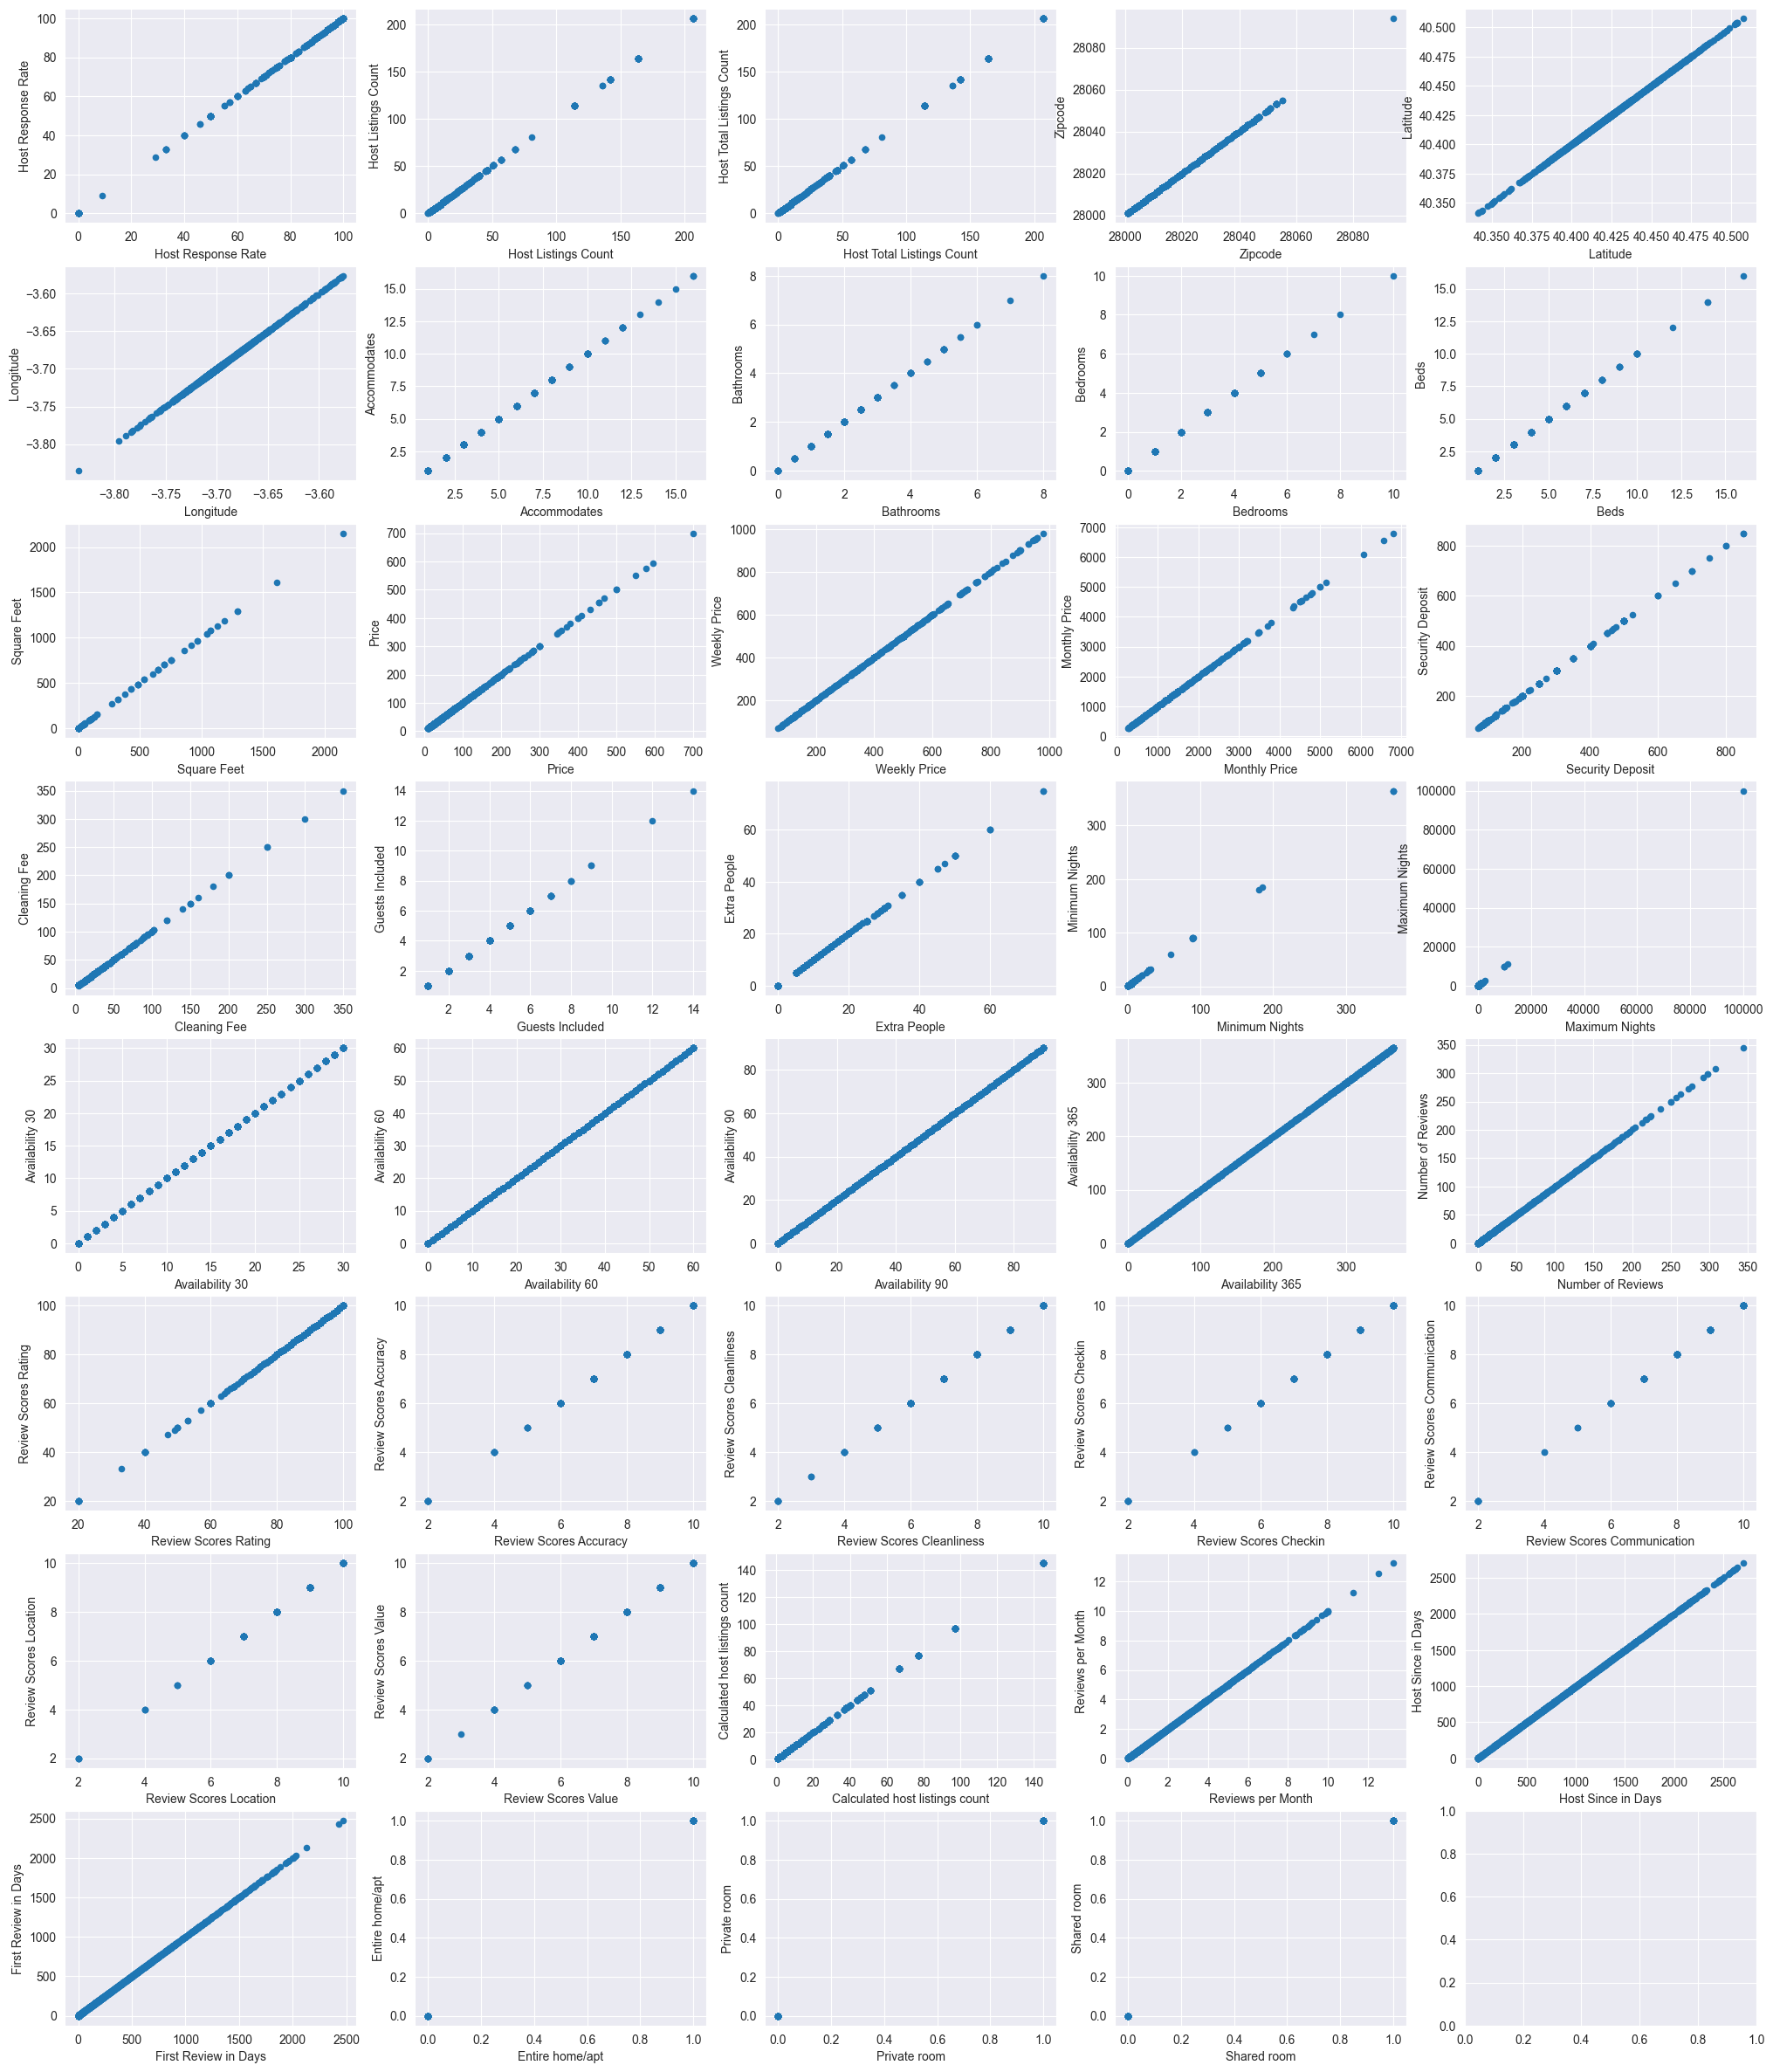

In [14]:
# Vamos a graficar cada columna en scatter para ver si hay outliers, lo vamos a mostrar en subplot
fig, ax = plt.subplots(8, 5, figsize=(25, 30))
for variable, subplot in zip(test_data.columns, ax.flatten()):
    test_data.plot(kind='scatter', x=variable, y=variable, ax=subplot)

In [17]:
# Aplicamos lo mismo que hicimos en train
# Obtenemos las filas del dataframe que, basados en la columna Zipcode, se consideran outliers
outliers = test_data[test_data['Zipcode'] > 99999]
print(outliers.index.to_list())
# Añadir al objeto outliers las filas del dataframe que, basados en la columna Montly Price, se consideran outliers
outliers = outliers.append(test_data[test_data['Monthly Price'] > 7000])
print(outliers.index.to_list())
# Obtenemos las filas del dataframe que, basados en la columna Square Feet, se consideran outliers
outliers = outliers.append(test_data[test_data['Square Feet'] > 2600])
# Obtenemos las filas del dataframe que, basados en la columna Cleaning Fee, se consideran outliers
outliers = outliers.append(test_data[test_data['Cleaning Fee'] > 299])
# Obtenemos las filas del dataframe que, basados en la columna Extra People, se consideran outliers
outliers = outliers.append(test_data[test_data['Extra People'] > 100])
# Obtenemos las filas del dataframe que, basados en la columna Minimum Nights, se consideran outliers
outliers = outliers.append(test_data[test_data['Minimum Nights'] > 40])
# Obtenemos las filas del dataframe que, basados en la columna Maximum Nights, se consideran outliers
outliers = outliers.append(test_data[test_data['Maximum Nights'] > 2500])

test_data = test_data.drop(outliers.index.to_list())

[]
[]


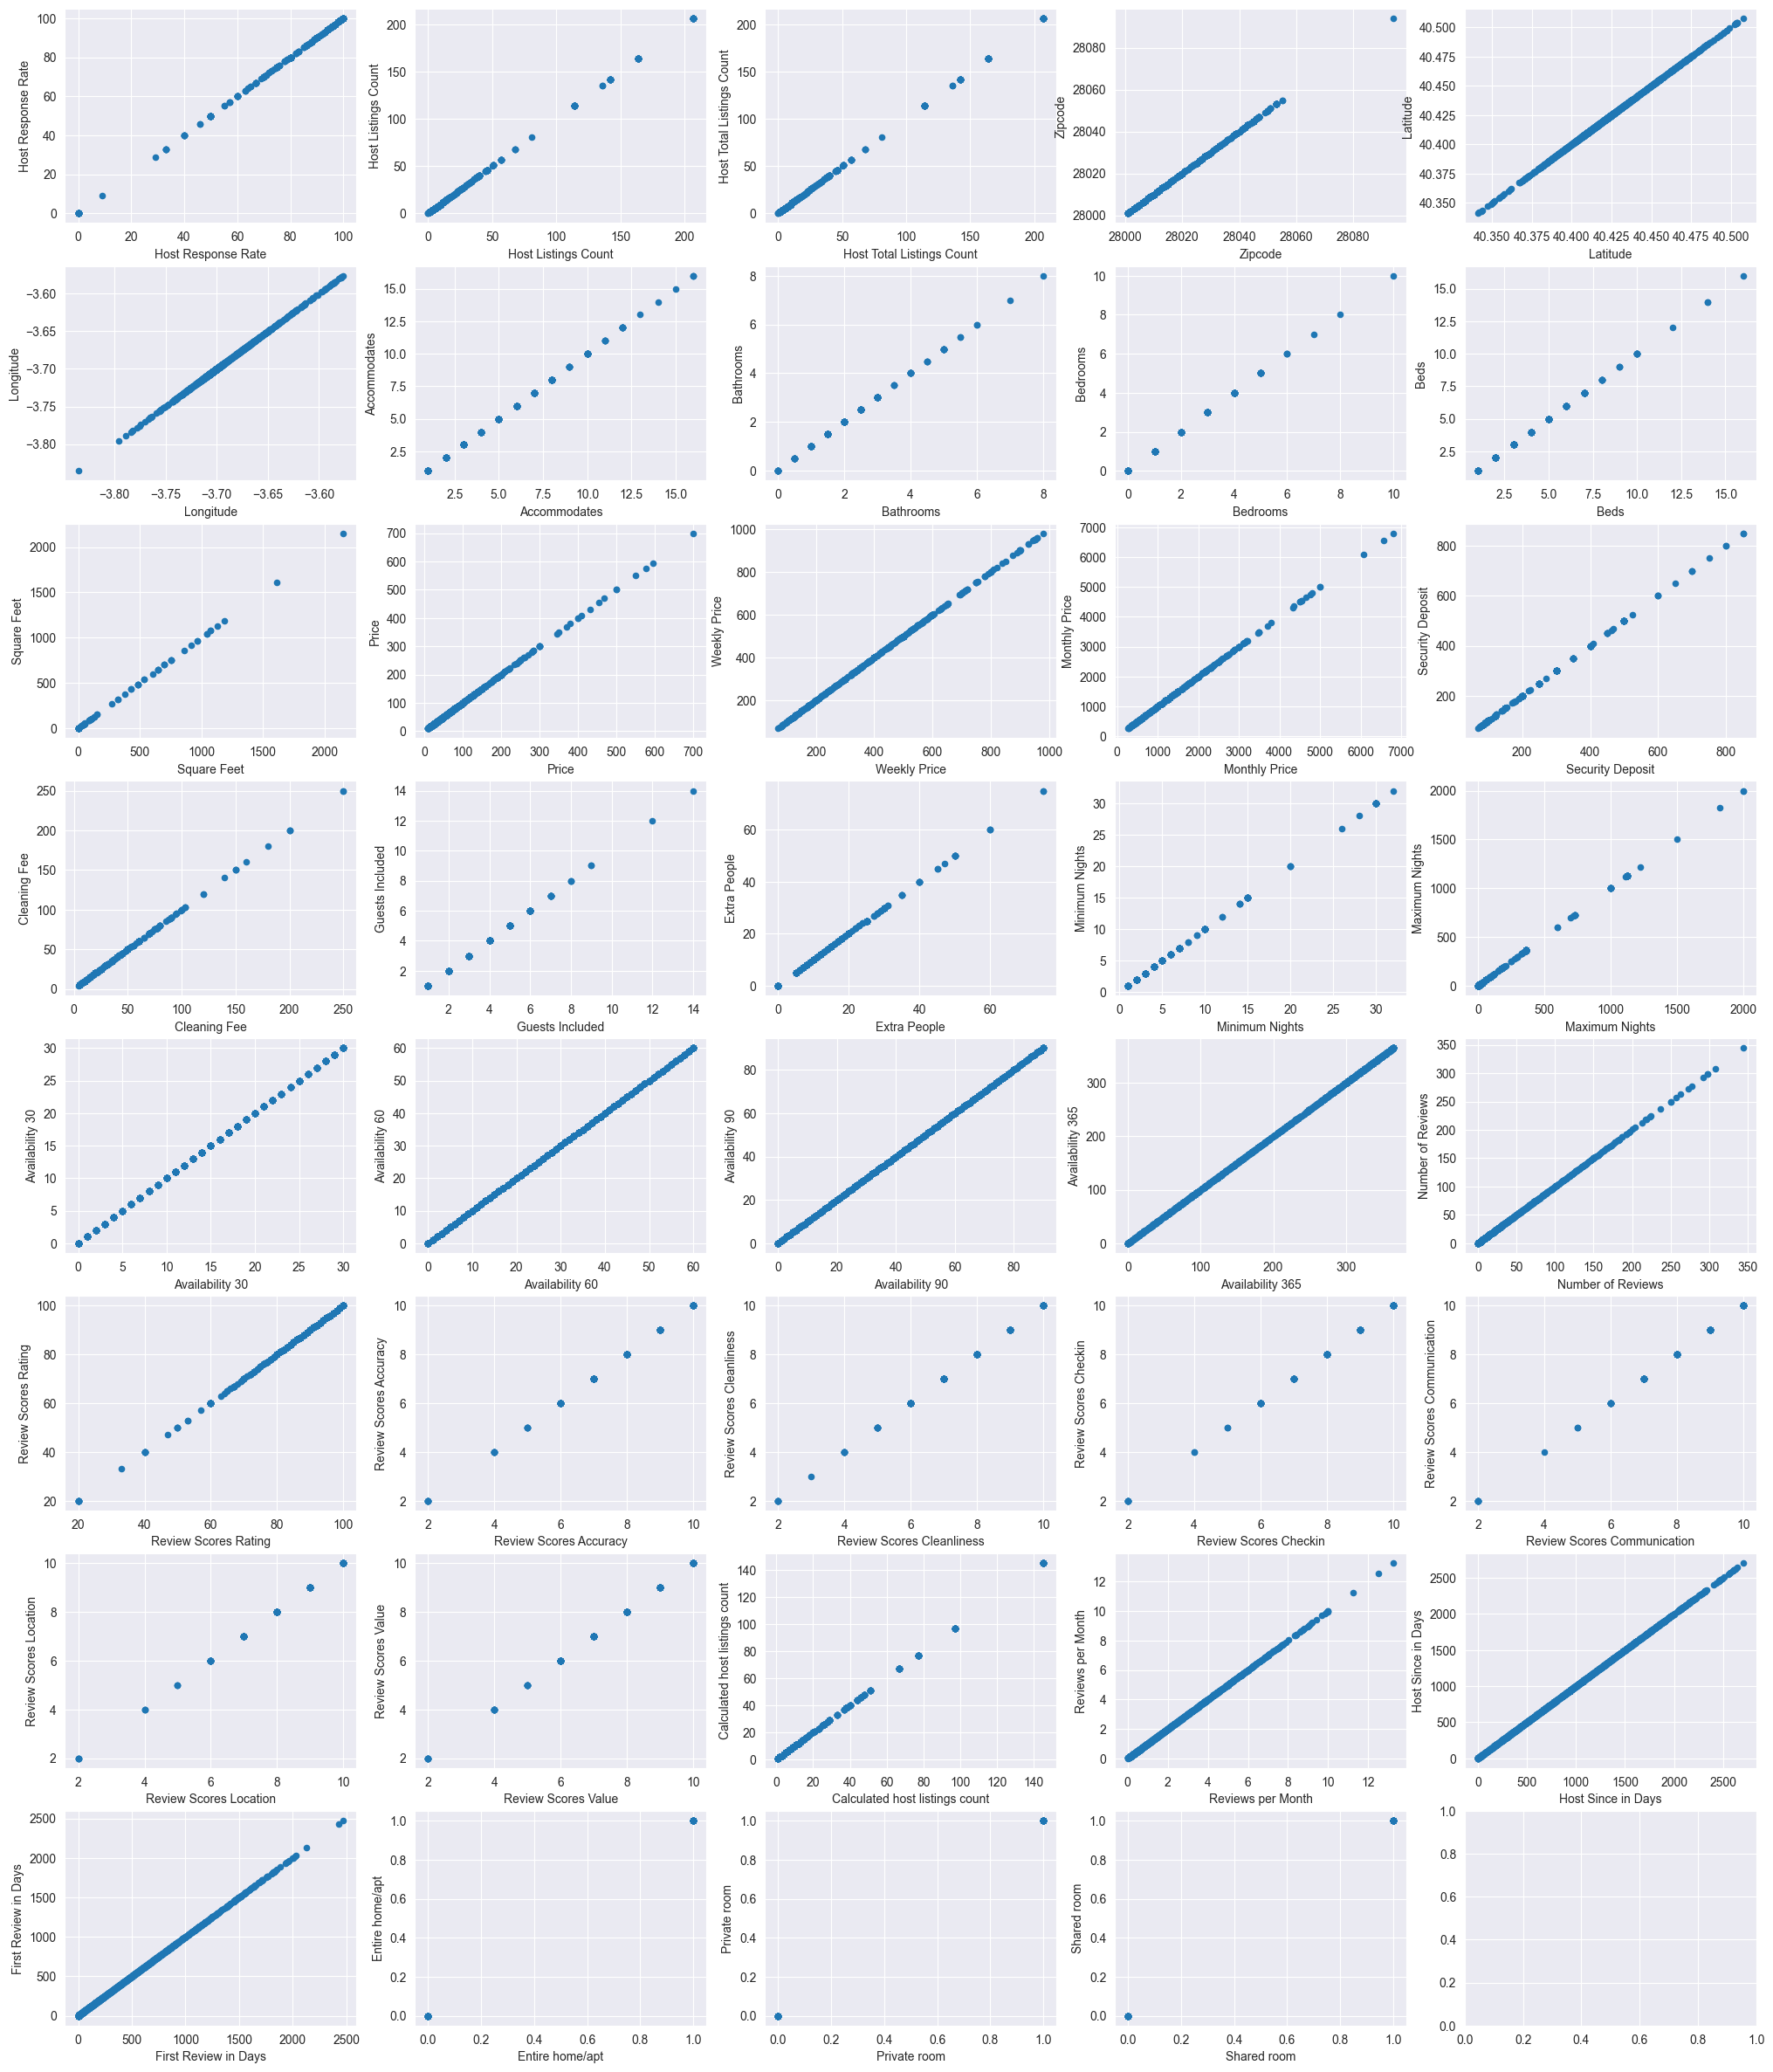

In [18]:
# Vamos a graficar cada columna en scatter para ver si hay outliers, lo vamos a mostrar en subplot
fig, ax = plt.subplots(8, 5, figsize=(25, 30))
for variable, subplot in zip(test_data.columns, ax.flatten()):
    test_data.plot(kind='scatter', x=variable, y=variable, ax=subplot)

In [19]:
# para la columna Zipcode vamos a reemplazar los outliers menores a 20000 por NaN
test_data['Zipcode'] = test_data['Zipcode'].apply(lambda x: np.nan if x < 20000 else x)


In [21]:
test_data['Square Feet'] = test_data['Square Feet'].apply(lambda x: np.nan if x == 0 else x)

<AxesSubplot: xlabel='Square Feet', ylabel='Price'>

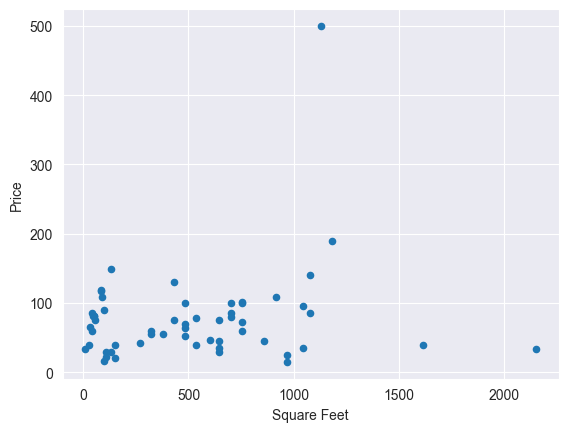

In [23]:
test_data.plot(kind='scatter', x='Square Feet', y='Price')

<AxesSubplot: xlabel='Square Feet', ylabel='Density'>

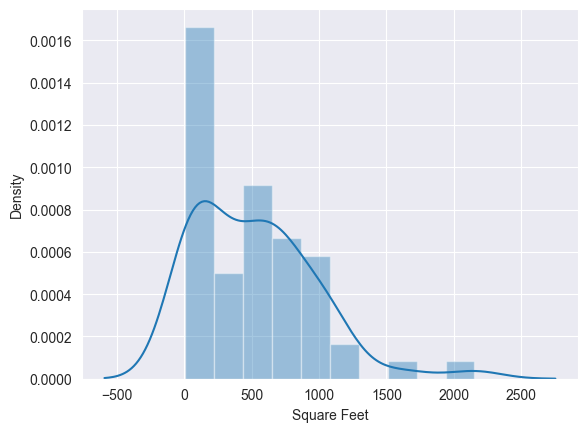

In [24]:
#### Por lo menos vemos en la grafica anterior que se parece a lo que teniamos en train.
sns.distplot(test_data['Square Feet'], hist=True, kde=True, bins=10)

<AxesSubplot: >

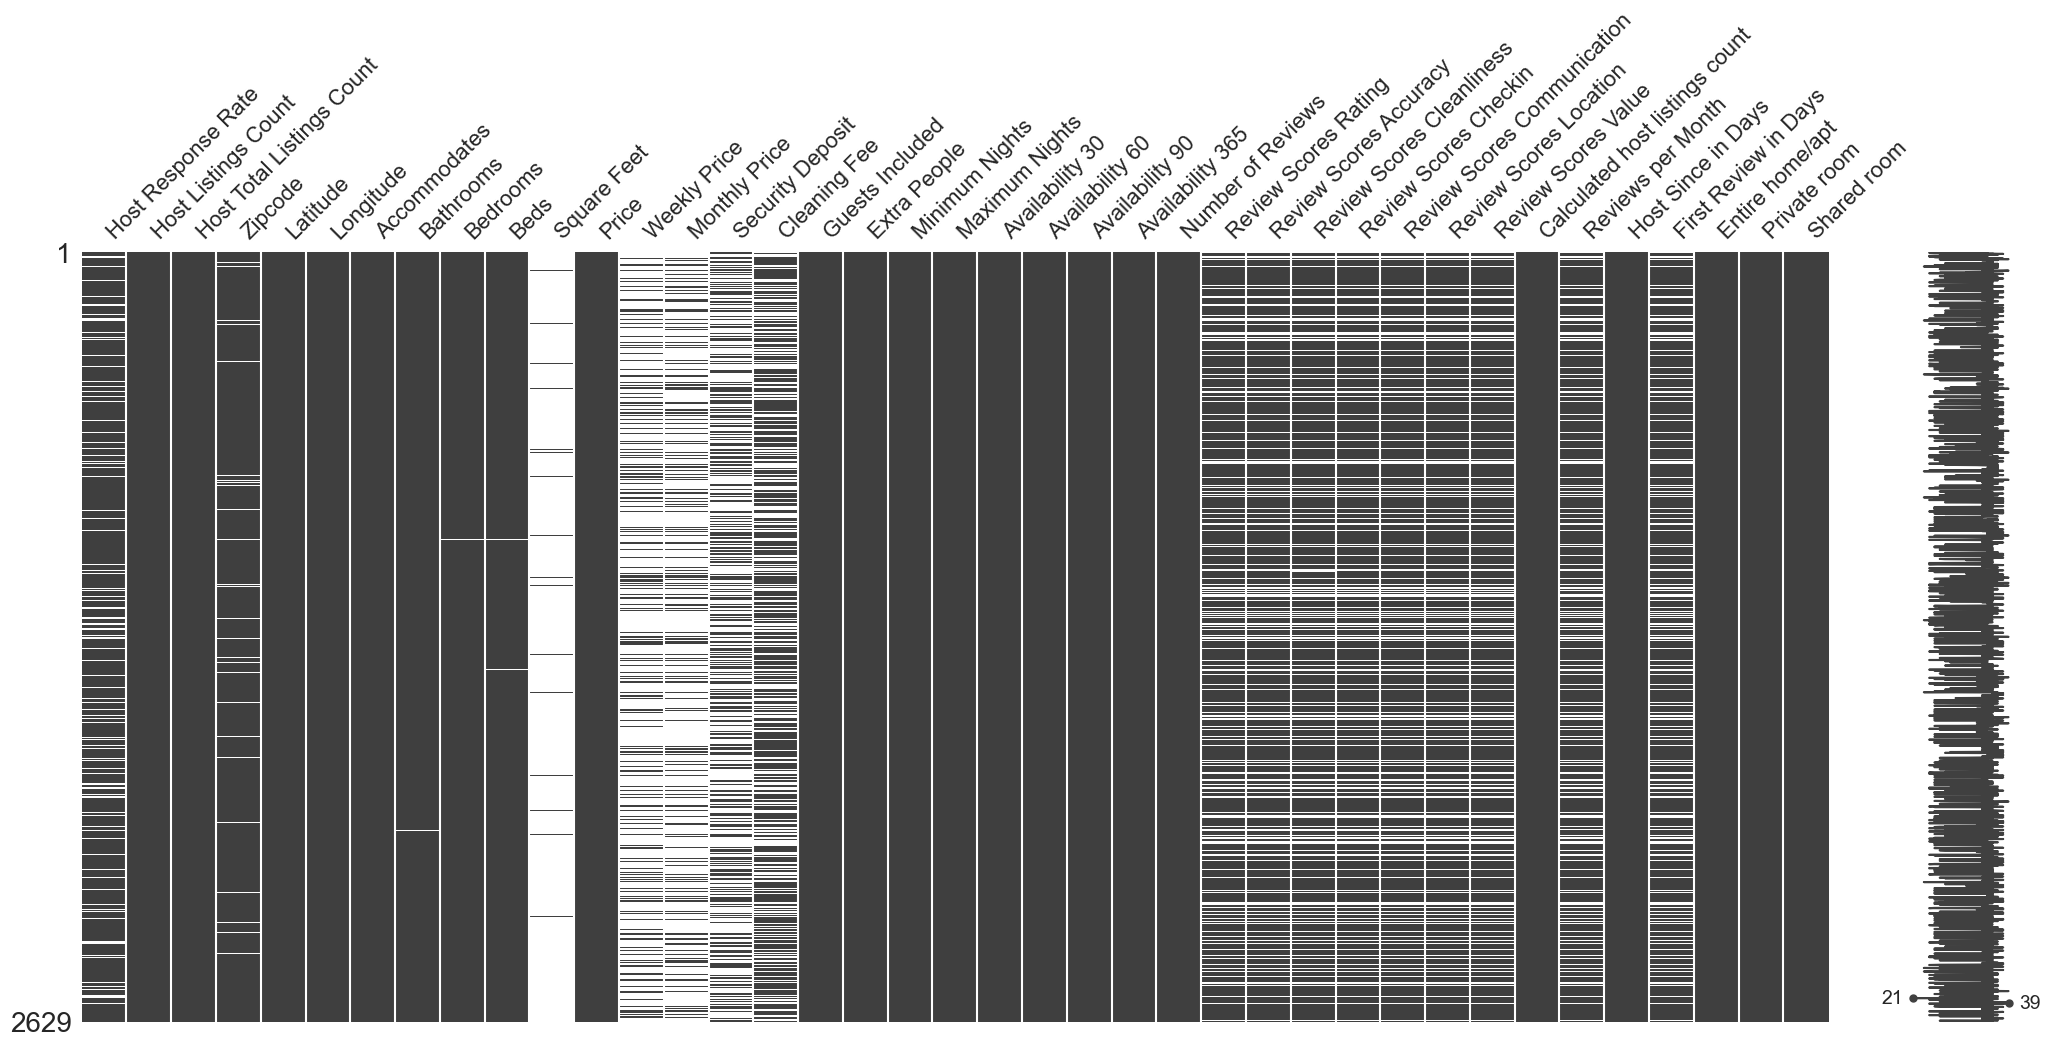

In [25]:
import missingno as msno

msno.matrix(test_data)

#### Viene lo mero bueno, vamos a comenzar a imputar como lo hicimos anteriormente

In [26]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# Vamos a obtener la lista de los porcentajes de valores faltantes ordenados de menor a mayor, vamos a ir recuperando datos de forma escalonada
lista_columnas = test_data.isnull().sum().sort_values(ascending=True).index.tolist()
# Vamos a recorrer la lista y conforme lo hagamos vamos a ir imputando los valores faltantes
corr = np.abs(test_data.corr())
# Hacemos una copia de nuestro dataframe
df_for_imputation = test_data.copy()
for columna in lista_columnas:
    columnas_relacionadas = corr[columna].sort_values(ascending=False).index.tolist()
    # Tomamos las columnas que tienen una correlación mayor a .39
    columnas_relacionadas = [x for x in columnas_relacionadas if corr[columna][x] > .39]
    # Tomamos las columnas que no son la columna que estamos analizando
    # columnas_relacionadas = [x for x in columnas_relacionadas if x != columna]
    print(f'Evaluando la columna {columna} con las variables relacionadas: {columnas_relacionadas}')
    # Creamos un dataframe con las variables que queremos imputar
    df_knn = df_for_imputation.filter(columnas_relacionadas, axis=1).copy()
    # Normalizamos los datos
    df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
    # Define KNN imputer and fill missing values
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)
    # Denormalize the data
    df_knn_imputed = pd.DataFrame(scaler.inverse_transform(df_knn_imputed), columns = df_knn_imputed.columns)
    # Asignamos los valores imputados a la variable original
    df_for_imputation[columna] = df_knn_imputed[columna]

Evaluando la columna Maximum Nights con las variables relacionadas: ['Maximum Nights']
Evaluando la columna Entire home/apt con las variables relacionadas: ['Entire home/apt', 'Private room', 'Weekly Price', 'Monthly Price', 'Accommodates', 'Price']
Evaluando la columna Calculated host listings count con las variables relacionadas: ['Calculated host listings count', 'Host Total Listings Count', 'Host Listings Count']
Evaluando la columna Number of Reviews con las variables relacionadas: ['Number of Reviews', 'First Review in Days', 'Reviews per Month']
Evaluando la columna Availability 365 con las variables relacionadas: ['Availability 365', 'Availability 90', 'Availability 60', 'Availability 30']
Evaluando la columna Availability 90 con las variables relacionadas: ['Availability 90', 'Availability 60', 'Availability 30', 'Availability 365']
Evaluando la columna Availability 60 con las variables relacionadas: ['Availability 60', 'Availability 90', 'Availability 30', 'Availability 365']

<AxesSubplot: xlabel='Square Feet', ylabel='Density'>

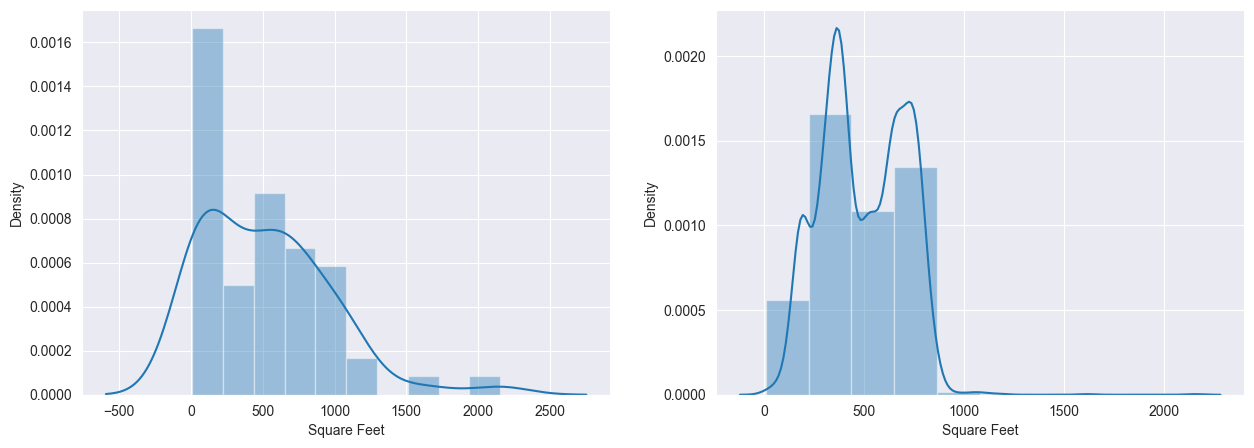

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Calculamos la similitud enntre la distribución de los datos originales y los datos imputados
sns.distplot(test_data['Square Feet'], hist=True, kde=True, bins=10, ax=ax[0])
sns.distplot(df_for_imputation['Square Feet'], hist=True, kde=True, bins=10, ax=ax[1])

#### Es un resultado algo similar con el que tuvimos anteriormente en train

In [63]:
## Tomamos solamente las variables que elegimos mediante random forest
import pickle
selected_features = []
with open('selected_features.pkl', 'rb') as infile:
    selected_features = pickle.load(infile)
selected_features

['bedrooms',
 'accommodates',
 'cleaning_fee',
 'bathrooms',
 'entire_home/apt',
 'beds',
 'private_room',
 'longitude',
 'monthly_price',
 'host_since_in_days',
 'latitude',
 'weekly_price',
 'zipcode',
 'availability_90',
 'security_deposit',
 'availability_365',
 'guests_included',
 'availability_60',
 'availability_30',
 'host_total_listings_count']

#### Cargamos nuestro dataset train

In [64]:
train_reduced = pd.read_csv("./train_reduced.csv", sep=';') # cargamos fichero
# Cambiamos el formato de las columnas de test
df_for_imputation = df_for_imputation.dropna()
df_for_imputation.columns = df_for_imputation.columns.str.replace(' ', '_').str.lower()
# Cambiamos square_feet a metros cuadrados generando una nueva columna
df_for_imputation['square_meters'] = df_for_imputation['square_feet'].apply(lambda x: x * 0.092903)
## Seleccionamos las caracteristicas que vamos a obtener
selected_features.append('price')
test_reduced = df_for_imputation[selected_features]
X_train = train_reduced.values[:, :-1]
y_train = train_reduced.values[:, -1]
X_test = test_reduced.values[:, :-1]
y_test = test_reduced.values[:, -1]
test_reduced.head()

,bedrooms,accommodates,cleaning_fee,bathrooms,entire_home/apt,beds,private_room,longitude,monthly_price,host_since_in_days,...,weekly_price,zipcode,availability_90,security_deposit,availability_365,guests_included,availability_60,availability_30,host_total_listings_count,price
0,1.0,2.0,25.0,1.0,1.0,1.0,0.0,-3.703841,1530.0,896.0,...,495.8,28004.0,4.0,140.0,192.0,1.0,1.0,1.0,2.0,42.0
1,1.0,2.0,33.8,1.0,0.0,1.0,1.0,-3.708362,754.6,278.0,...,301.0,28019.0,81.0,100.0,81.0,1.0,51.0,21.0,1.0,25.0
2,1.0,3.0,25.0,1.5,1.0,1.0,0.0,-3.795734,1404.0,1709.0,...,423.0,28023.0,0.0,277.0,0.0,1.0,0.0,0.0,1.0,70.0
3,2.0,3.0,35.0,2.0,1.0,2.0,0.0,-3.663459,1200.0,1035.0,...,450.0,28033.0,0.0,200.0,0.0,2.0,0.0,0.0,1.0,79.0
4,0.0,3.0,35.0,1.0,1.0,1.0,0.0,-3.701552,1167.8,720.0,...,565.0,28012.0,18.0,170.0,211.0,2.0,11.0,7.0,6.0,70.0


### Aplicamos SVM a ver que tal nos va

In [45]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [65]:
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled  = scaler.transform(X_test)

In [47]:
from sklearn.svm import SVR

# Paso 2:
vectorC = np.logspace(-2, 2, 10)
vectorG = np.logspace(-5, 1, 8)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=2)
grid.fit(XtrainScaled, y_train)



Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ................................C=0.01, gamma=1e-05; total time=   8.1s
[CV] END ................................C=0.01, gamma=1e-05; total time=   6.5s
[CV] END ................................C=0.01, gamma=1e-05; total time=   6.4s
[CV] END ................................C=0.01, gamma=1e-05; total time=   6.4s
[CV] END ................................C=0.01, gamma=1e-05; total time=   6.5s
[CV] END ................C=0.01, gamma=7.196856730011514e-05; total time=   6.8s
[CV] END ................C=0.01, gamma=7.196856730011514e-05; total time=   6.4s
[CV] END ................C=0.01, gamma=7.196856730011514e-05; total time=   6.4s
[CV] END ................C=0.01, gamma=7.196856730011514e-05; total time=   6.4s
[CV] END ................C=0.01, gamma=7.196856730011514e-05; total time=   6.5s
[CV] END ................C=0.01, gamma=0.0005179474679231213; total time=   6.5s
[CV] END ................C=0.01, gamma=0.000517

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-05, 7.19685673e-05, 5.17947468e-04, 3.72759372e-03,
       2.68269580e-02, 1.93069773e-01, 1.38949549e+00, 1.00000000e+01])},
             verbose=2)

best mean cross-validation score: 0.588
best parameters: {'C': 100.0, 'gamma': 0.026826957952797246}
Log de los best params. C: 2.0 Gamma: -1.5714285714285716


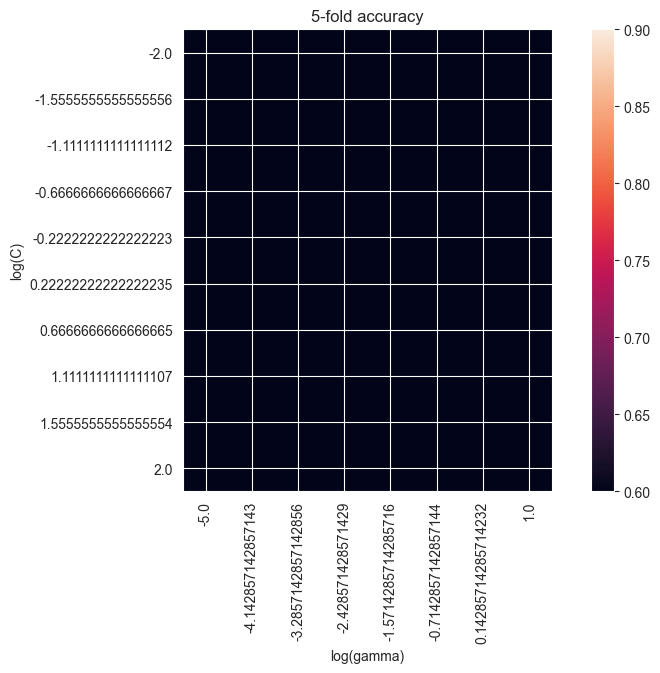

In [48]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print(f'Log de los best params. C: {np.log10(grid.best_params_["C"])} Gamma: {np.log10(grid.best_params_["gamma"])}')

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('5-fold accuracy')
plt.show()


#### Revisamos a ver la barbaridad que nos dio

In [66]:
# Paso 3:
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svmModel = SVR(kernel='rbf',gamma = Gopt, C = Copt).fit(XtrainScaled,y_train)
print('Acc (TEST): %0.2f'%svmModel.score(XtestScaled,y_test))

Acc (TEST): 0.56
